# Compare Different Machine Learning Models
This notebook compares the ability of three different machine learning models to predict the glass forming ability of metallic glasses via sputtering:

1. A model using only melt-spinning data from the literature
1. A model using melt-spinning and sputtering data from literature
1. A model using using all literature data, and the HiTp data for Co-V-Zr

In [39]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
from cycler import cycler
from sklearn import metrics
import numpy as np
import pandas as pd
import json
import os

Variables to change

In [2]:
fig_width = 89 / 25.4
fig_height = fig_width
fig_dpi = 320
fig_name = os.path.join('..','..','figures','Figure5b_ROC-comparison.png')

In [13]:
models = [
    ('Only Meltspin', 'cv_Only_Meltspin.json'),
    ('With Sputtering', 'cv_LB.json'),
    ('Iteration 1', 'cv_LB+CoVZr.json'),
    ('Iteration 2', 'cv_LB+CoVZr+FeTiNb.json'),
    ('Iteration 3', 'cv_LB+CoVZr+FeTiNb+CoFeZr.json'),
    ('Iteration 4', 'cv_LB+CoVZr+FeTiNb+CoFeZr+CoTiZr.json'),
]

## Load in the Data
The data from each test is stored in JSON files. These are in Magpie format

In [14]:
def load_data(filename):
    # Load in data as JSON, convert to dataframe
    temp_data = json.load(open(filename))
    data = pd.DataFrame(temp_data['entries'])
    
    # Get the measured and predicted classes probabilities
    data['measured'] = [x['measured'] for x in data['class'] ]
    data['prob_AM'], data['prob_CR'] = zip(*[x['probabilities'] for x in data['class']])
    
    # Drop unneeded columns and return result
    return data.drop(['attributes','class','properties'], axis='columns')

In [16]:
data = [(x,load_data(os.path.join('results',y))) for x,y in models]

Compute performance scores

In [17]:
def compute_scores(data):
    return dict(
        auc=metrics.roc_auc_score(data['measured'], data['prob_CR']), 
        logloss=metrics.log_loss(data['measured'], data['prob_CR'])
    )

In [87]:
scores = [(x,compute_scores(y)) for x,y in data]

In [85]:
pd.DataFrame(dict(scores))

,Iteration 1,Iteration 2,Iteration 3,Iteration 4,Only Meltspin,With Sputtering
auc,0.833545,0.846138,0.803349,0.793243,0.671643,0.735781
logloss,0.840703,0.721362,0.593416,0.614480,11.672092,1.895626


<Container object of 6 artists>

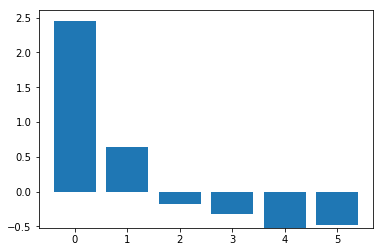

In [93]:
fig, ax = plt.subplots()

ax.bar(range(len(scores)), np.log([x[1]['logloss'] for x in scores]))

## Plot the ROC Curves

In [72]:
def compute_roc(data):
    return metrics.roc_curve(data['measured'], data['prob_AM'], pos_label=0)[:2]

In [73]:
roc_data = [(x,compute_roc(y)) for x,y in data]

In [86]:
for x,roc in roc_data:
    pd.DataFrame({'FPR':roc[0], 'TPR':roc[1]}).to_csv('results/%s.csv'%x.replace(' ',''), index=False)

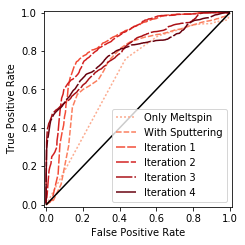

In [74]:
fig, ax = plt.subplots()

# Set the color loop
cmap = cm.get_cmap('Reds')
ax.set_prop_cycle(cycler('color', [cmap(x) for x in np.linspace(0.3,1,len(roc_data))]) +
                                  cycler('dashes', [(x,1) for x in np.linspace(1,10,len(roc_data))]))

for name,roc in roc_data:
    ax.plot(roc[0], roc[1], label=name)

ax.plot([0,1],[0,1], 'k-', dashes=(1000,1))

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim([-0.01,1.01])
ax.set_ylim([-0.01,1.01])

ax.legend()

fig.set_size_inches(fig_width, fig_height)
fig.tight_layout()

fig.savefig(fig_name)